In [220]:
import cv2
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
# import the necessary packages
from skimage import feature
import glob
from skimage.filters import threshold_otsu
from sklearn import svm
import time
from copy import deepcopy
from sklearn.metrics import accuracy_score

In [221]:
#############----------------------IO function-----------------#############
# This function reads forms from folders representing each iteration inside folder data
def readData(folderName):

    trainingImagePaths = []
    trainingLabels = []
    for trainingPath, trainingWriterFolder in enumerate(sorted(glob.glob(folderName + "/*/"))):
      
        trainingFiles = sorted(glob.glob(trainingWriterFolder + "/*.PNG"))
        trainingImagePaths += trainingFiles

        trainingLabels += [trainingPath]*len(trainingFiles)

    testingFormPath = glob.glob(folderName + "/*.PNG")[0]

    return trainingImagePaths, testingFormPath,trainingLabels


In [262]:
def LocalBinaryPatternHistogram(numPoints,radius,image):

    lbp = feature.local_binary_pattern(image, numPoints,radius, method="nri_uniform")
    (hist, _) = np.histogram(lbp.ravel(),bins=np.arange(0, numPoints + 3),range=(0,numPoints + 2))
    # normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum())
    # return the histogram of Local Binary Patterns
    return hist
    

In [263]:
#This function extracts the text part only from IAM image 
def crop_text(image):
   # Load image, convert to grayscale, Otsu's threshold
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
 

    # Detect horizontal lines
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (80,1))
    detect_horizontal = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
    cnts = cv2.findContours(detect_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    #upper horizontal
    x,y,w,h = cv2.boundingRect(cnts[-2])

    #lower horizontal
    x1,y1,w1,h1 = cv2.boundingRect(cnts[0])
  
    #final text only extract
    gray=gray[y+h+5:y1,:]

    #done cropping from horizontal lines
    #continue to remove extra white space

    # Create rectangular structuring element and dilate
    blur = cv2.GaussianBlur(gray, (7,7), 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (31,31))
    dilate = cv2.dilate(thresh[y+h+5:y1,:], kernel, iterations=4)
 
    # Find contours and draw rectangle
    cnts = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        x,y,w,h = cv2.boundingRect(c)
        largest = max(cnts, key = cv2.contourArea)

    xf,yf,wf,hf = cv2.boundingRect(largest)
    cv2.rectangle(blur,(xf,yf),(xf+wf,yf+hf),(0,255,0),2) 
    prepro_img=blur[yf:yf+hf, xf:xf+wf]
    thresh = cv2.threshold(prepro_img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    return prepro_img,thresh


In [252]:
##########################################################################################################################

(107, 1958)


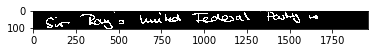

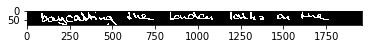

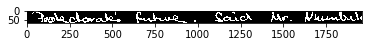

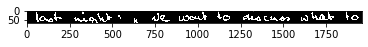

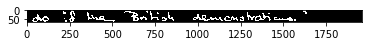

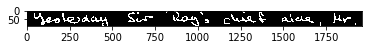

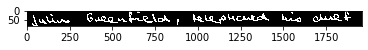

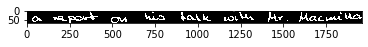

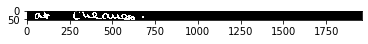

In [253]:
# This function preprocesses a form

# This function splits a sequence of numbers on a given value (smallest)
def splitz(seq, smallest):
    group = []
    for i in range(len(seq)):
        if (seq[i] >= (smallest)):
            group.append(i)
        elif group:
            yield group
            group = []


def preprocessForm(filename):
    # Read image and convert it to binary
    img = cv2.imread(filename)

    image,binarizedImage=crop_text(img) 
    gray_img=deepcopy(image)
    image[binarizedImage == 0] = 0
    image[binarizedImage == 255] = 1
  
    verticalHistogram = image.sum(axis=1)
    smallest = int(np.average(verticalHistogram) - np.min(verticalHistogram)) / 4
    
    linesArrays = splitz(verticalHistogram, int(smallest))
   
    horizontalHistogram = image.sum(axis=0)
   
    smallest = int(np.average(horizontalHistogram) - np.min(horizontalHistogram)) / 4
    marginsArrays = (list(splitz(horizontalHistogram[30:], smallest)))

    counter = 0
    extractedLines = []
    extractedLines_gray=[]

    # For each array (representing a line) extracted, perform some preprocessing operations
    for arr in (linesArrays):
        if (arr[-1] - arr[0] > 30):
            line = image[arr[0]:arr[-1], marginsArrays[0][0]:marginsArrays[-1][-1]]
            line[line != 0] = 255
            extractedLines.append(line)
            
            line_gray = gray_img[arr[0]:arr[-1], marginsArrays[0][0]:marginsArrays[-1][-1]]
            extractedLines_gray.append(line_gray)
            
            counter += 1

    return extractedLines,extractedLines_gray

extractedLines,extractedLines_gray=preprocessForm("Test Samples/data/01/1.png")
print(extractedLines[0].shape)

for line in extractedLines:
    plt.imshow(line,cmap='gray')
    plt.show()

In [255]:
#############-----------------FEATURES---------------#####################
#extract Features
def getFeatures(extractedLines,extractedLines_gray):
    interword=[]
    hist=[]
    for i,j in zip(extractedLines,extractedLines_gray):
        
        hist.append(LocalBinaryPatternHistogram(8,2,i))
    
    return hist
    
features= getFeatures(extractedLines,extractedLines_gray)
# print(features.len)



In [256]:
# This function is used to return features vectors and their labels
def getFeaturesAndLabels(filename, labelVal, formsFeaturesVectors, labels):
    
    print("current image is ", filename)
   
    extractedLines,gray = preprocessForm(filename)
    
    featuresVectors = np.array(getFeatures(extractedLines,gray))  
    #featuresVectors=featuresVectors.reshape(1,-1)
    
    print(featuresVectors.shape)
    #print(featuresVectors)
    
    formsFeaturesVectors = np.vstack((formsFeaturesVectors, featuresVectors)) 
    
    for i in range(featuresVectors.shape[0]):
        labels.append(labelVal)

    return np.array(formsFeaturesVectors), labels

# This function returns training features and corresponding labels of all test case
def getTrainingData(trainingFormIDs, trainingLabels, yTrain, formsFeaturesVectors):
    
    for trainingIndex, formID in enumerate(trainingFormIDs):
        formsFeaturesVectors, labels= getFeaturesAndLabels(formID, trainingLabels[trainingIndex], formsFeaturesVectors, yTrain)

    xTrain = np.array(formsFeaturesVectors)
    yTrain = np.array(yTrain)
    
    return xTrain, yTrain

# This function is used to return test features vectors
def getTestFeatures(filename, formsFeaturesVectors):
    print("current image is ", filename)
    extractedLines,gray = preprocessForm(filename)

    featuresVectors = np.array(getFeatures(extractedLines,gray))
        
    formsFeaturesVectors = np.vstack((formsFeaturesVectors, featuresVectors))
            
    return np.array(formsFeaturesVectors)

In [257]:
# This function applies SVM classifier on test features given training set
def SVM(xTrain, yTrain, xTest):
    
    clf = svm.SVC(gamma='scale')
    clf.fit(xTrain, yTrain)
    predictions = clf.predict(xTest)

    uniquePredictions, uniquePredictionsCount = np.unique(predictions, return_counts=True)
    classification = uniquePredictions[np.argmax(uniquePredictionsCount)]
    return classification, predictions

In [258]:
# This function writes the classified class to a results.txt file and the time of training and testing in time.txt file
def writeOutput(classification, t1, t0):
    f = open("results.txt", "a")
    f.write(str(classification + 1) + "\n")
    f.close()

    f = open("time.txt", "a")
    f.write(str(round(t1 - t0, 2)) + "\n")
    f.close()


In [266]:
#######-------------------------MAIN---------------------------######
##Global variables

featuresCount = 10 

# create output files
f = open("results.txt", "w+")
f.close()
f = open("time.txt", "w+")
f.close()

for TestFolder in sorted(glob.glob("data/*")):
    
    trainingImagePaths, testingImagePath, trainingLabels = readData(TestFolder)
   
    t0 = time.time()
    
    xTrain = np.empty([0, featuresCount])
    yTrain = []
    xTest = np.empty([0, featuresCount])
    featuresVectors = []
    ImageFeaturesVectors = np.empty([0, featuresCount])
    testFeaturesVectors = np.empty([0, featuresCount])
    
    
    xTrain, yTrain = getTrainingData(trainingImagePaths, trainingLabels, yTrain, ImageFeaturesVectors)
    
    xTest= getTestFeatures(testingImagePath, testFeaturesVectors)
    
    classification, predictions=SVM(xTrain, yTrain, xTest)
    
    t1 = time.time()
    writeOutput(classification, t1, t0)


current image is  data\01\1\a01-000x.png
(6, 10)
current image is  data\01\1\a01-072x.png
(8, 10)
current image is  data\01\2\a01-000u.png
(7, 10)
current image is  data\01\2\a01-003u.png
(11, 10)
current image is  data\01\3\a01-003x.png
(9, 10)
current image is  data\01\3\a01-007x.png
(8, 10)
current image is  data\01\1.png
current image is  data\02\1\a01-011.png
(7, 10)
current image is  data\02\1\a01-030.png
(8, 10)
current image is  data\02\2\b01-044.png
(7, 10)
current image is  data\02\2\b01-049.png
(8, 10)
current image is  data\02\3\a01-014.png
(10, 10)
current image is  data\02\3\a01-038.png
(12, 10)
current image is  data\02\2.png
current image is  data\03\1\a01-014x.png
(10, 10)
current image is  data\03\1\a01-026x.png
(10, 10)
current image is  data\03\2\a01-020.png
(9, 10)
current image is  data\03\2\a01-026.png
(10, 10)
current image is  data\03\3\a04-000.png
(7, 10)
current image is  data\03\3\a04-003.png
(8, 10)
current image is  data\03\3.png
current image is  data\04\

In [60]:
1 2 3 2 2 1 3

SyntaxError: invalid syntax (<ipython-input-60-4176bed20f18>, line 1)